# 3D-BPP

## Pre-requisites

In [1]:
import sys

sys.path.append("src/")

In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm


import config, dataset, main, utils, bins

In [3]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [5]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

width  depth  height  weight    volume
0    160    280     233       8  10438400
1    199    269     260      11  13918060
2    187    101     283       2   5345021
3    126    149     214       2   4017636
4    248    132     280       3   9166080

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


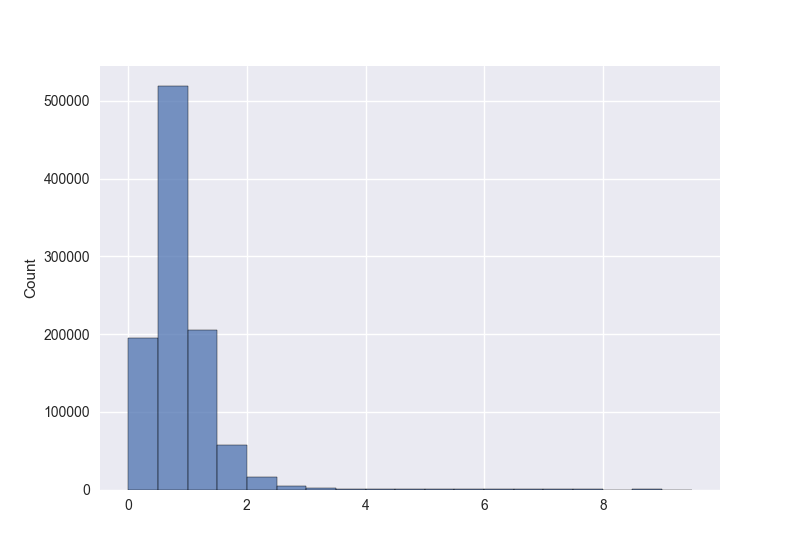

<IPython.core.display.Javascript object>

In [125]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


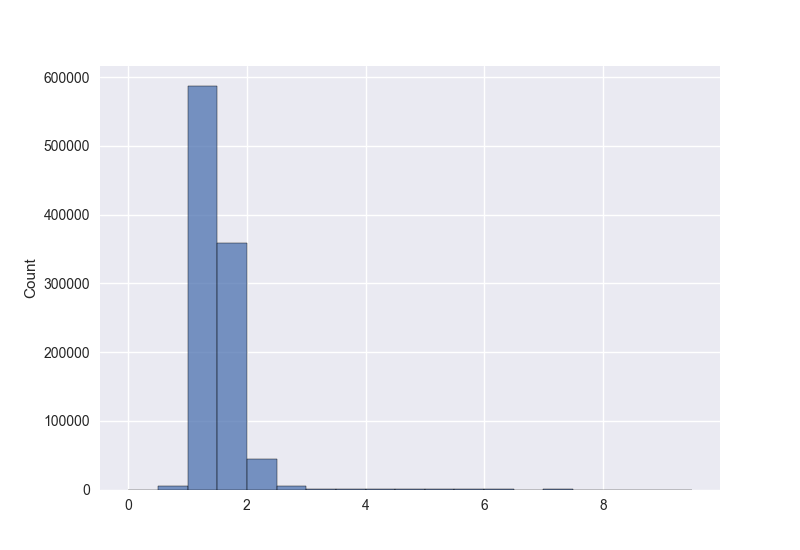

<IPython.core.display.Javascript object>

In [126]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


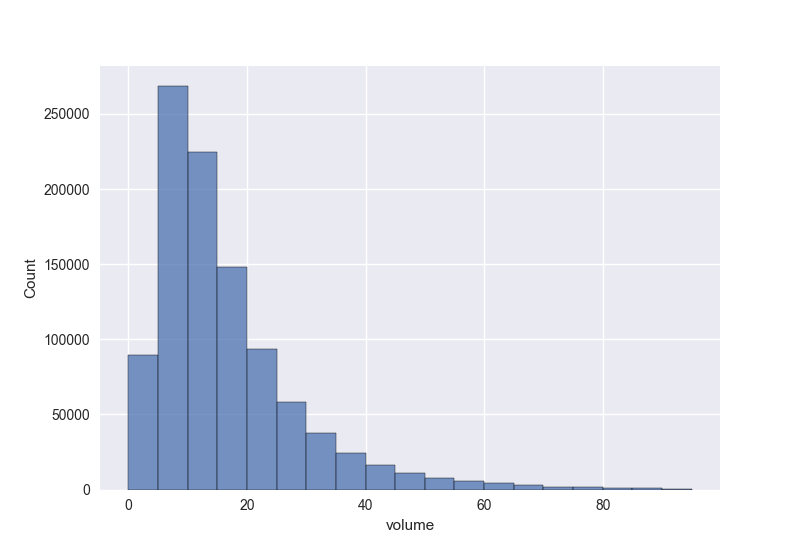

<IPython.core.display.Javascript object>

In [127]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


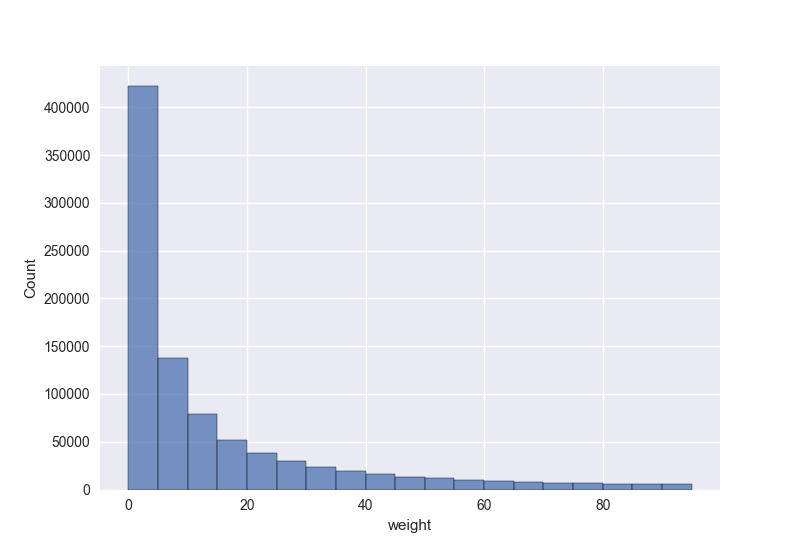

<IPython.core.display.Javascript object>

In [128]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


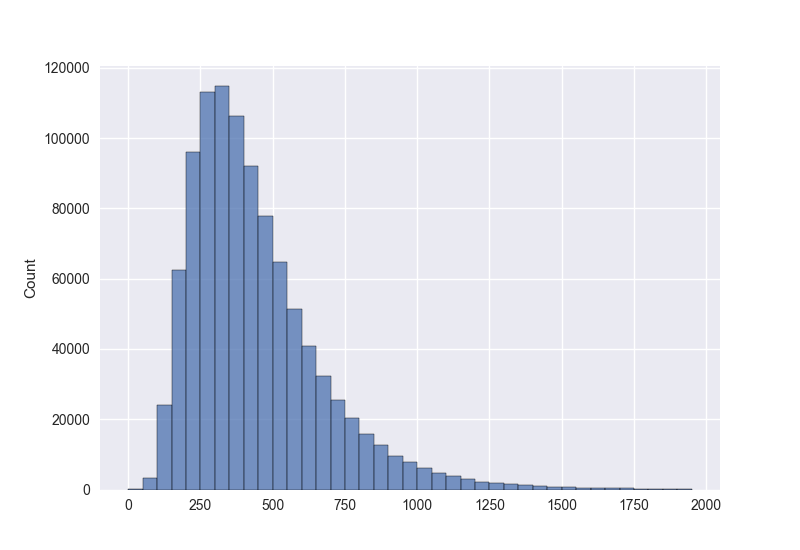

<IPython.core.display.Javascript object>

In [129]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [6]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

id  width  depth  height  weight    volume
0  121958    193    221     371       2  15824263
1  671155    236    142     437      58  14644744
2  131932    228    139     254      26   8049768
3  365838    267    131     322      11  11262594
4  259178    253    191     580      68  28027340

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [131]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [132]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [133]:
bl_order = product_dataset.get_order(20)

<IPython.core.display.Javascript object>

In [138]:
bl_bin_pool = main.main(bl_order, procedure="bl", tlim=20)
bl_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-14 14:45:07.238 | INFO     | main:main:166 - BL procedure starting
2021-08-14 14:45:07.239 | INFO     | main:main:176 - BL iteration 1/1
2021-08-14 14:45:07.242 | DEBUG    | superitems:_gen_single_items_superitems:634 - Generated 20 superitems with a single item
2021-08-14 14:45:07.243 | INFO     | superitems:gen_superitems:618 - Generating horizontal superitems of type 'two-width'
2021-08-14 14:45:07.243 | DEBUG    | superitems:_gen_superitems_horizontal:680 - Generated 0 horizontal superitems with 2 items
2021-08-14 14:45:07.244 | DEBUG    | superitems:_gen_superitems_horizontal:687 - Generated 0 horizontal superitems with 4 items
2021-08-14 14:45:07.244 | INFO     | superitems:gen_superitems:621 - Generating vertical superitems with maximum stacking of 4
2021-08-14 14:45:07.245 | DEBUG    | superitems:_gen_superitems_vertical:765 - Generated 15 wide vertical superitems
2021-08-14 14:45:07.246 | DEBUG    | superitems:_gen_superitems_vertical:767 - Generated 1 deep vertical su

item     x    y    z  width  depth  height  layer
0      0   481  602    0    213    188     313      0
1      1   532    1    0    300    291     444      0
2      2   704  668    0    317    110     484      0
3      3   245    1    0    287    157     333      0
4      5  1021  602    0    177    174     226      0
5      6   849    0    0    350    287     441      0
6      7   242  397    0    219    205     393      0
7      8   365  302    0    339     84     417      0
8      9   570  443    0    123    159     227      0
9     11   242  602    0    239    159     354      0
10    12     0  443    0    225     93     327      0
11    13   245  158    0    187    144     281      0
12    14   901  458    0    269    144     283      0
13    17     1  536    0    241    231     350      0
14    18     0  346    0    240     97     304      0
15    19   694  386    0    207    282     352      0
16    15   926  326    0    192    132     201      0
17    16   901  337  201    242    109     289      0
18     4     1   17    0    244    312     333      0
19    10     4    1  333    238    345     289      0

<IPython.core.display.Javascript object>

In [ ]:
bl_bin_pool.get_original_layer_pool().describe()

<IPython.core.display.Javascript object>


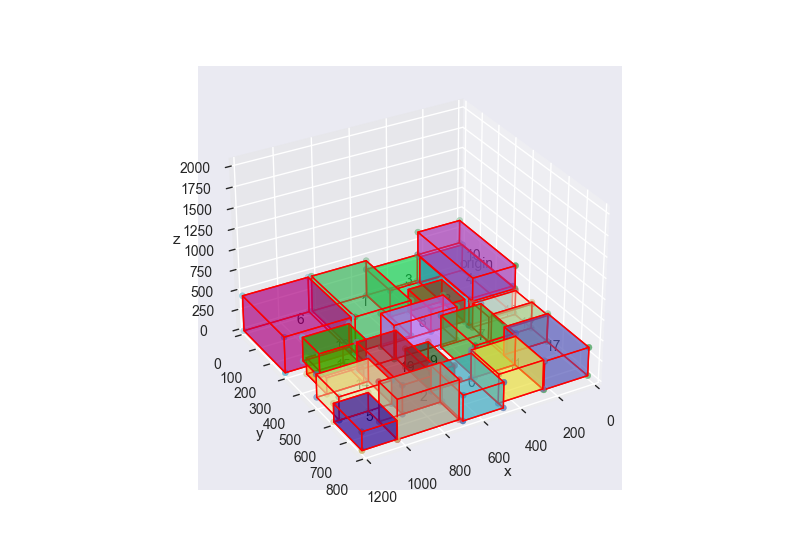

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [139]:
bl_bin_pool.get_original_bin_pool().plot();

<IPython.core.display.Javascript object>


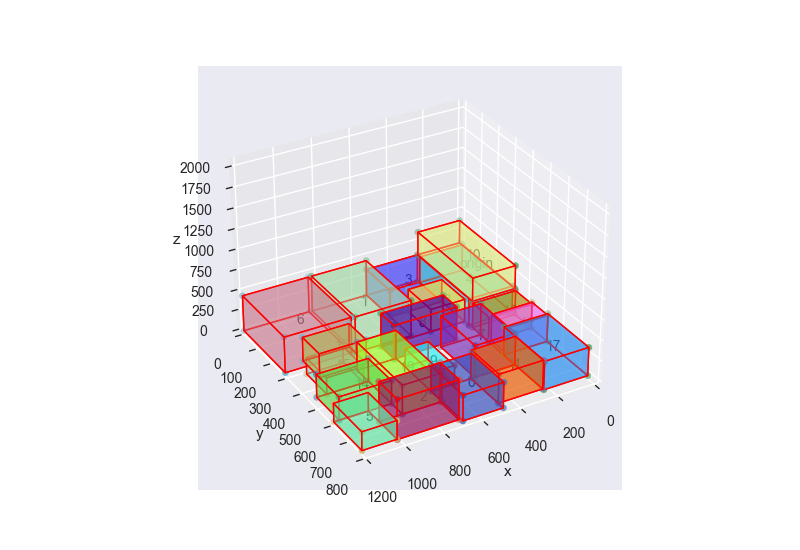

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [140]:
bl_bin_pool.plot();

## Maxrects

In [9]:
mr_bin_pool = main.main(
    order,
    procedure="mr",
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
)
mr_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-19 12:39:13.172 | INFO     | main:main:169 - MR procedure starting
2021-08-19 12:39:13.173 | INFO     | main:main:179 - MR iteration 1/1
2021-08-19 12:39:13.184 | DEBUG    | superitems:_gen_single_items_superitems:639 - Generated 100 superitems with a single item
2021-08-19 12:39:13.185 | INFO     | superitems:gen_superitems:623 - Generating horizontal superitems of type 'two-width'
2021-08-19 12:39:13.185 | DEBUG    | superitems:_gen_superitems_horizontal:685 - Generated 0 horizontal superitems with 2 items
2021-08-19 12:39:13.186 | DEBUG    | superitems:_gen_superitems_horizontal:692 - Generated 0 horizontal superitems with 4 items
2021-08-19 12:39:13.186 | INFO     | superitems:gen_superitems:626 - Generating vertical superitems with maximum stacking of 4
2021-08-19 12:39:13.188 | DEBUG    | superitems:_gen_superitems_vertical:770 - Generated 80 wide vertical superitems
2021-08-19 12:39:13.189 | DEBUG    | superitems:_gen_superitems_vertical:772 - Generated 24 deep vertical 

item    x    y  z  width  depth  height  layer
0     33    0    0  0    268    313     456      0
1     45    0  313  0    186    378     351      0
2     58    0  691  0    339     84     417      0
3     40  186  313  0    273    257     325      0
4     52  186  570  0    317    110     484      0
..   ...  ...  ... ..    ...    ...     ...    ...
95    92  299    0  0    254    179     448      5
96    51  553    0  0    300    291     444      5
97    56    0  179  0    350    287     441      5
98    57  853    0  0    219    205     393      5
99    90  853  205  0    235    155     372      5

[100 rows x 8 columns]

<IPython.core.display.Javascript object>

In [21]:
mr_bin_pool.get_original_layer_pool().describe()

layer  height       area        volume  2d_density  3d_density
0      0   510.0   803651.0  2.932651e+08    0.837136    0.598989
1      1   580.0   883366.0  3.331470e+08    0.920173    0.598324
2      2   601.0   820530.0  3.343484e+08    0.854719    0.579500
3      3   654.0   834859.0  3.372537e+08    0.869645    0.537165
4      4   363.0   753155.0  2.199760e+08    0.784536    0.631244
5      5   486.0   350715.0  1.522052e+08    0.365328    0.326229
6  Total  3194.0  4446276.0  1.670196e+09    0.771923    0.545242

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


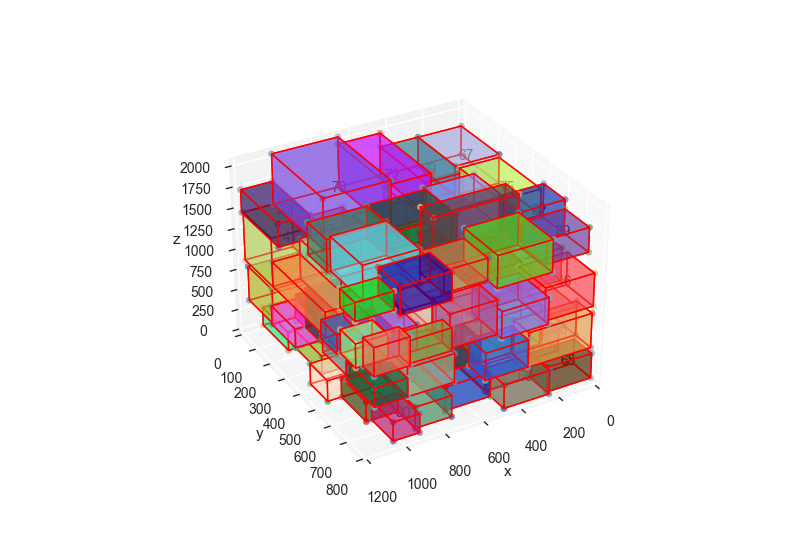

<IPython.core.display.Javascript object>


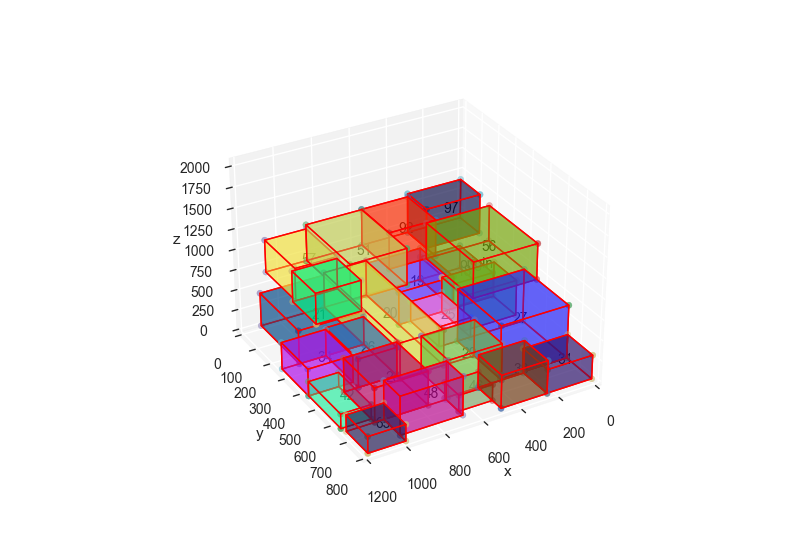

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [10]:
mr_bin_pool.get_original_bin_pool().plot();

<IPython.core.display.Javascript object>


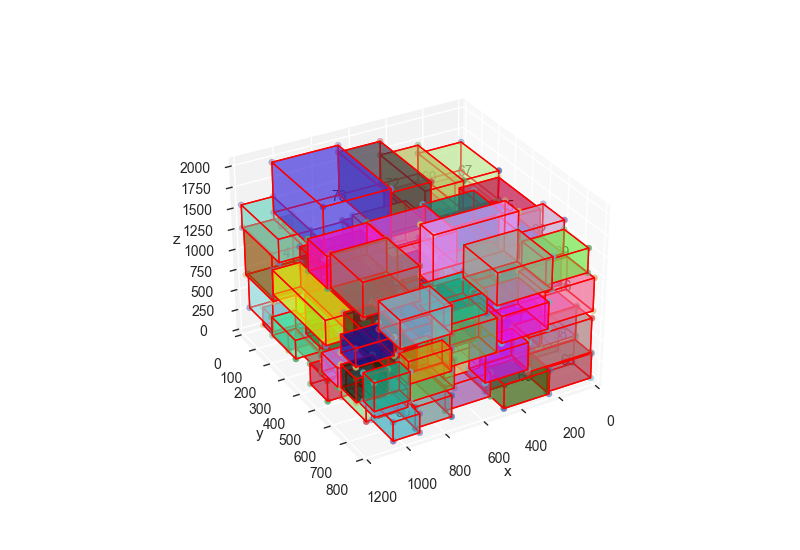

<IPython.core.display.Javascript object>


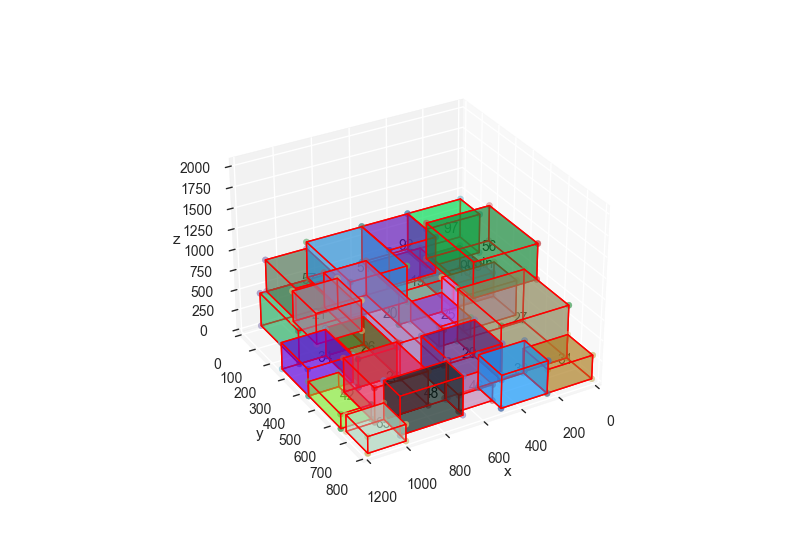

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [11]:
mr_bin_pool.plot();

## Column generation

In [29]:
cg_bin_pool = main.main(
    order,
    procedure="cg",
    max_iters=1,
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
    tlim=5,
    cg_use_height_groups=False,
    cg_mr_warm_start=False,
    cg_max_iters=100,
    cg_max_stag_iters=10,
    cg_sp_mr=True,
    cg_sp_np_type="mip",
    cg_sp_p_type="mr",
    cg_return_only_last=False,
)
cg_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-19 12:50:32.914 | INFO     | main:main:169 - CG procedure starting
2021-08-19 12:50:32.915 | INFO     | main:main:179 - CG iteration 1/1
2021-08-19 12:50:32.926 | DEBUG    | superitems:_gen_single_items_superitems:639 - Generated 100 superitems with a single item
2021-08-19 12:50:32.927 | INFO     | superitems:gen_superitems:623 - Generating horizontal superitems of type 'two-width'
2021-08-19 12:50:32.928 | DEBUG    | superitems:_gen_superitems_horizontal:685 - Generated 0 horizontal superitems with 2 items
2021-08-19 12:50:32.929 | DEBUG    | superitems:_gen_superitems_horizontal:692 - Generated 0 horizontal superitems with 4 items
2021-08-19 12:50:32.930 | INFO     | superitems:gen_superitems:626 - Generating vertical superitems with maximum stacking of 4
2021-08-19 12:50:32.931 | DEBUG    | superitems:_gen_superitems_vertical:770 - Generated 80 wide vertical superitems
2021-08-19 12:50:32.932 | DEBUG    | superitems:_gen_superitems_vertical:772 - Generated 24 deep vertical 

2021-08-19 12:50:33.838 | DEBUG    | column_generation:master_problem:123 - RMP constraints: 100
2021-08-19 12:50:33.839 | DEBUG    | column_generation:master_problem:125 - RMP iterations: 89
2021-08-19 12:50:33.840 | INFO     | column_generation:master_problem:131 - RMP solved
2021-08-19 12:50:33.841 | DEBUG    | column_generation:master_problem:135 - RMP alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

2021-08-19 12:50:34.455 | DEBUG    | column_generation:master_problem:137 - RMP solution not feasible (at least one alpha value is not binary)
2021-08-19 12:50:34.456 | DEBUG    | column_generation:master_problem:141 - RMP objective: 3938.0000000000005
2021-08-19 12:50:34.458 | DEBUG    | column_generation:master_problem:146 - RMP duals: [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  323.    0.    0.    0.    0.    0.  441.    0.    0.    0.
   0.    0.  349.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  325.  283.5   0.    0.    0.    0.    0.    0.
  13.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.  289.    0.    0.    0.  231.    0.
   0.    0.    0.  313.    0.  387.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.  290.    0.    0.    0.  330.    0.  363.
   0.    0.    0.    0. ]
2021-08-19 12:50:34.458 | DEBUG    | column_generation:mas

2021-08-19 12:50:35.074 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.274
2021-08-19 12:50:35.077 | DEBUG    | column_generation:column_generation:654 - CG stagnation 4/10
2021-08-19 12:50:35.078 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-08-19 12:50:35.083 | DEBUG    | maxrects:maxrects_single_layer_online:137 - MR-SL-Online starting
2021-08-19 12:50:35.086 | DEBUG    | maxrects:maxrects_single_layer_online:146 - MR-SL-Online 36 non-zero duals to place
2021-08-19 12:50:35.100 | DEBUG    | maxrects:maxrects_single_layer_online:195 - MR-SL-Online generated a new layer with 17 superitems (of which 12 with non-zero dual) and 0.44136730684488834 3D density
2021-08-19 12:50:35.101 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-08-19 12:50:35.102 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02274012565612793
2021-08-19 12:50:35.103 | INFO     | column_generatio

2021-08-19 12:50:35.698 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.28
2021-08-19 12:50:35.702 | DEBUG    | column_generation:column_generation:654 - CG stagnation 6/10
2021-08-19 12:50:35.703 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-08-19 12:50:35.707 | DEBUG    | maxrects:maxrects_single_layer_online:137 - MR-SL-Online starting
2021-08-19 12:50:35.710 | DEBUG    | maxrects:maxrects_single_layer_online:146 - MR-SL-Online 44 non-zero duals to place
2021-08-19 12:50:35.724 | DEBUG    | maxrects:maxrects_single_layer_online:195 - MR-SL-Online generated a new layer with 17 superitems (of which 14 with non-zero dual) and 0.4742106267197327 3D density
2021-08-19 12:50:35.725 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-08-19 12:50:35.726 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.022307872772216797
2021-08-19 12:50:35.726 | INFO     | column_generation

2021-08-19 12:50:36.332 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.284
2021-08-19 12:50:36.336 | DEBUG    | column_generation:column_generation:654 - CG stagnation 8/10
2021-08-19 12:50:36.337 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-08-19 12:50:36.341 | DEBUG    | maxrects:maxrects_single_layer_online:137 - MR-SL-Online starting
2021-08-19 12:50:36.344 | DEBUG    | maxrects:maxrects_single_layer_online:146 - MR-SL-Online 53 non-zero duals to place
2021-08-19 12:50:36.360 | DEBUG    | maxrects:maxrects_single_layer_online:195 - MR-SL-Online generated a new layer with 18 superitems (of which 16 with non-zero dual) and 0.36033551800100705 3D density
2021-08-19 12:50:36.361 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-08-19 12:50:36.361 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.023652076721191406
2021-08-19 12:50:36.362 | INFO     | column_generati

2021-08-19 12:50:36.956 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.282
2021-08-19 12:50:36.960 | DEBUG    | column_generation:column_generation:654 - CG stagnation 10/10
2021-08-19 12:50:36.961 | ERROR    | column_generation:column_generation:658 - CG exiting for stagnation
2021-08-19 12:50:36.966 | INFO     | layers:filter_layers:483 - Filtering 111 generated layers
2021-08-19 12:50:36.970 | DEBUG    | layers:filter_layers:485 - Remaining 2 layers after discarding by 0.5 density
2021-08-19 12:50:36.973 | DEBUG    | layers:filter_layers:489 - Remaining 2 layers after discarding by coverage (all: 3, single: 3)
2021-08-19 12:50:36.998 | DEBUG    | maxrects:maxrects_single_layer_offline:87 - MR-SL-Offline starting
2021-08-19 12:50:36.999 | DEBUG    | maxrects:maxrects_single_layer_offline:93 - MR-SL-Offline [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]/14 superitems to place
2021-08-19 12:50:37.007 | ERROR    | layers:remove_duplicated_items:459 - After removing duplica

item    x    y     z  width  depth  height  layer
0     29    0   22     0    286    162     450      0
1     76    5   18   450    275    171     380      0
2     18   29    0   830    228    207     292      0
3      4   16    8  1122    253    191     580      0
4     27    0  246     0    366    256     654      0
..   ...  ...  ...   ...    ...    ...     ...    ...
95    22  244  176     0    294    136     440      3
96    61  475    0     0    239    159     354      3
97    65  341  312     0    192    132     201      3
98    94  419  444     0    231    128     345      3
99    82  533  312     0    239    119     398      3

[100 rows x 8 columns]

<IPython.core.display.Javascript object>

In [30]:
cg_bin_pool.get_original_layer_pool().describe()

layer  height       area        volume  2d_density  3d_density
0      0  1702.0   837966.0  9.786522e+08    0.872881    0.598960
1      1   289.0   818369.0  2.099312e+08    0.852468    0.756672
2      2   519.0   860836.0  3.328284e+08    0.896704    0.668008
3      3   440.0   433351.0  1.487837e+08    0.451407    0.352234
4  Total  2950.0  2950522.0  1.670196e+09    0.768365    0.593969

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


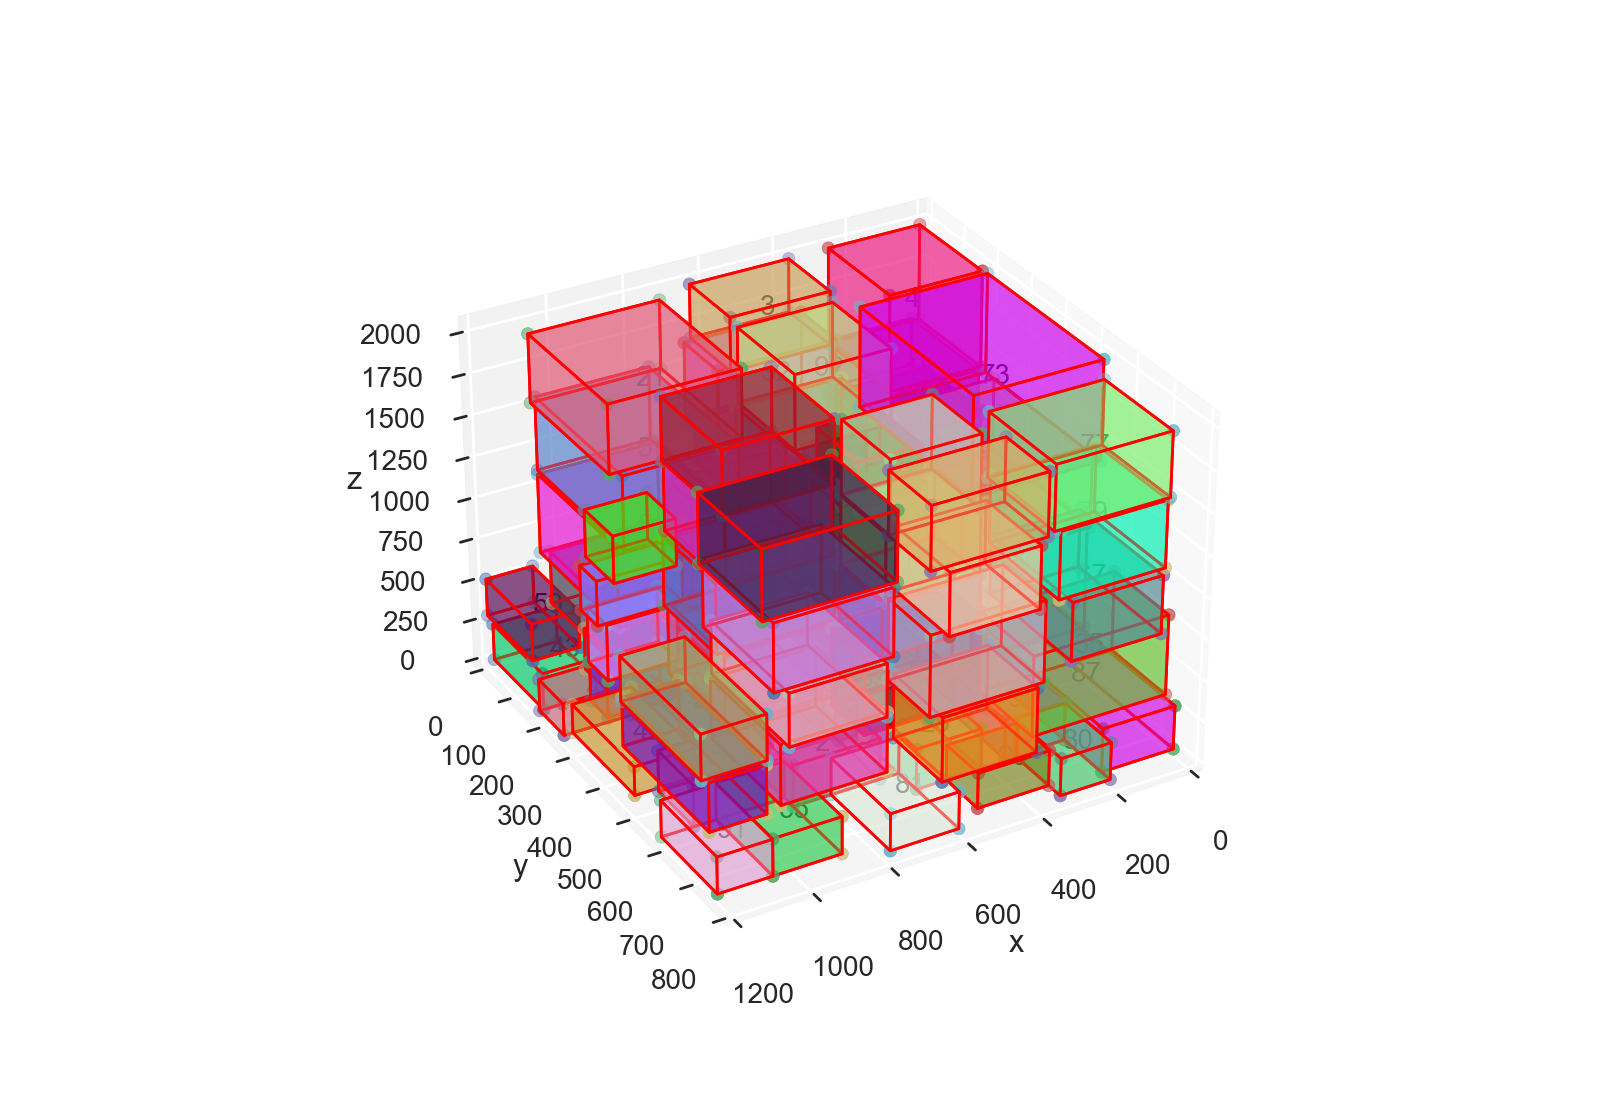

<IPython.core.display.Javascript object>


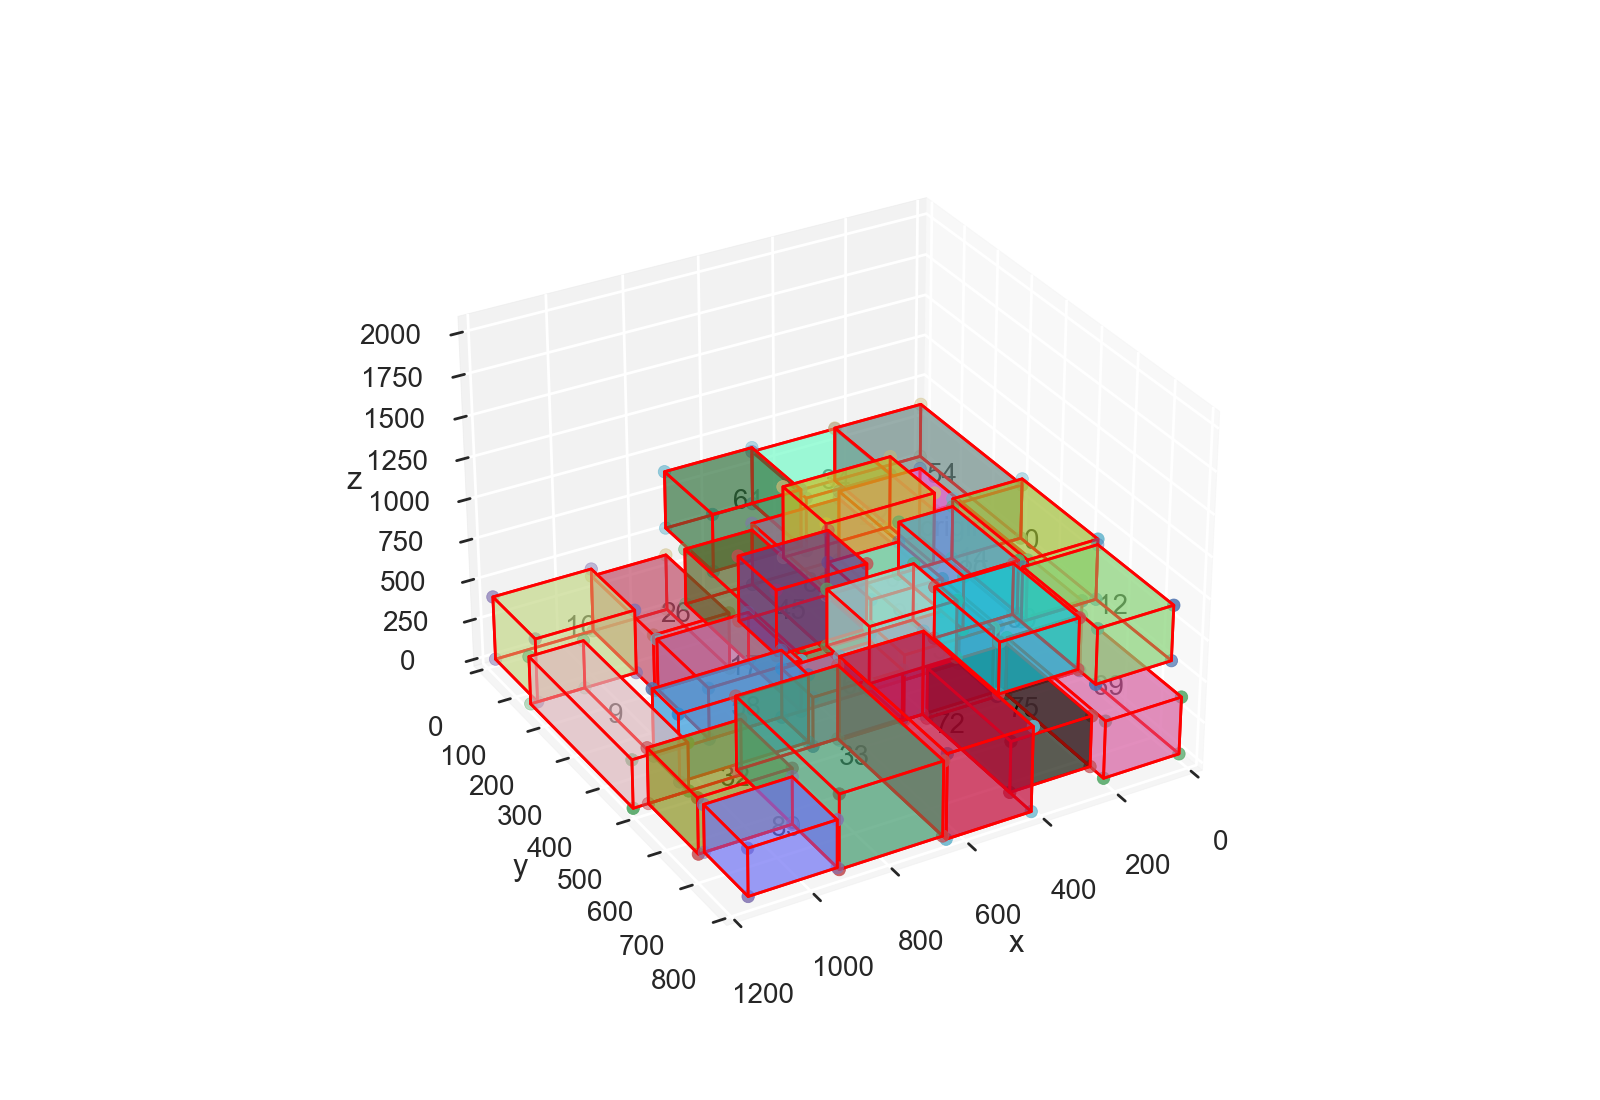

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [31]:
cg_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


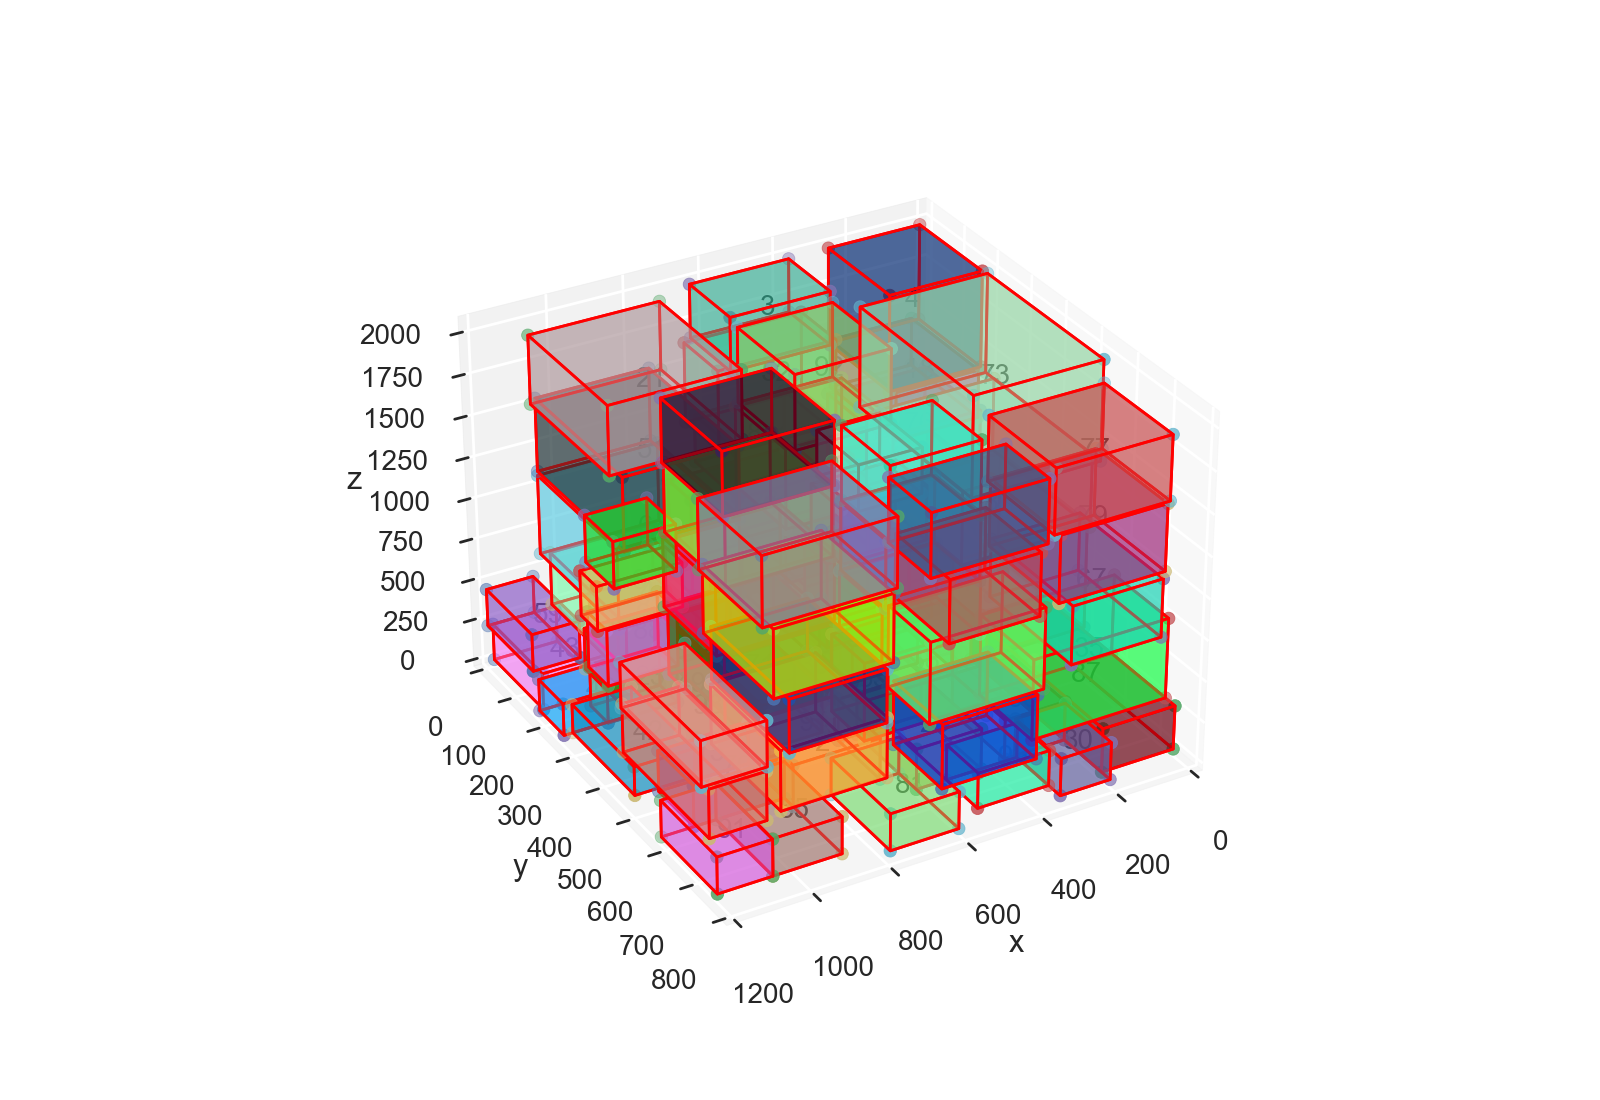

<IPython.core.display.Javascript object>


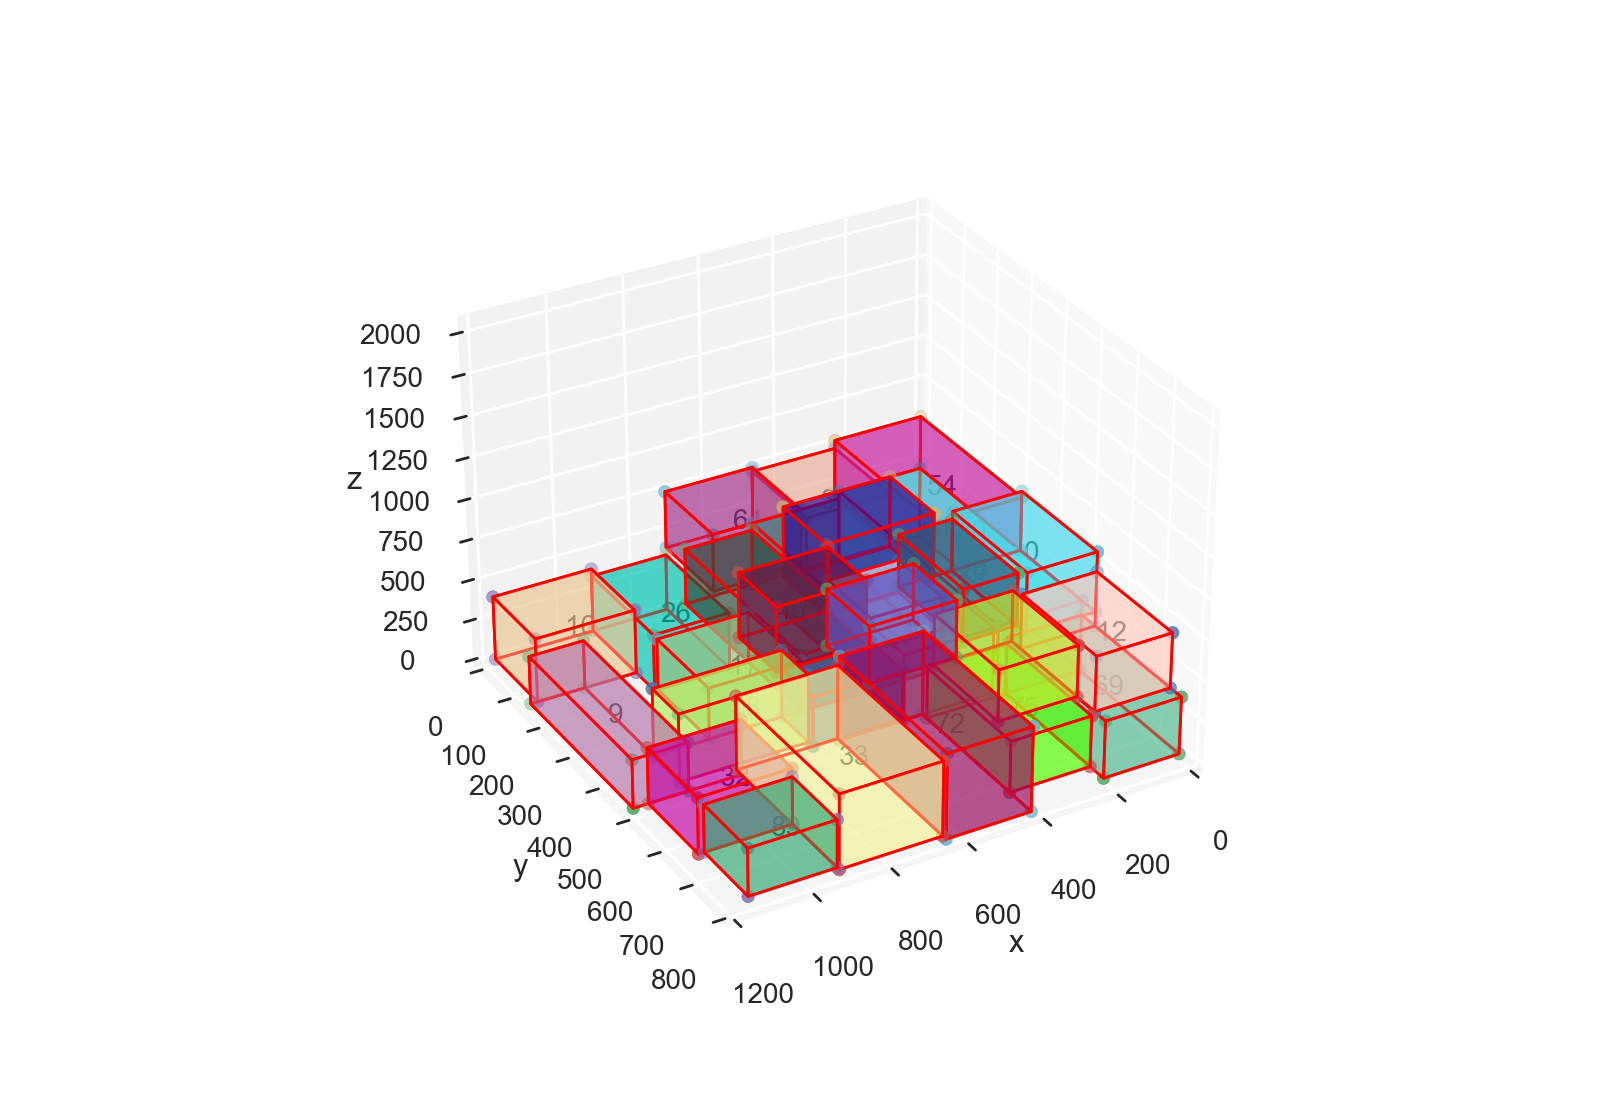

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [32]:
cg_bin_pool.plot()

## Comparison

In [19]:
diff = (
    cg_bin_pool.get_original_layer_pool()
    .to_dataframe()
    .merge(
        mr_bin_pool.get_original_layer_pool().to_dataframe(),
        on="item",
        suffixes=("_cg", "_mr"),
    )
)
diff["xd"] = diff["x_cg"] - diff["x_mr"]
diff["yd"] = diff["y_cg"] - diff["y_mr"]
diff["zd"] = diff["z_cg"] - diff["z_mr"]
diff[["item", "xd", "yd", "zd"]]

item  xd  yd  zd
0     33   0   0   0
1     45   0   0   0
2     58   0   0   0
3     40   0   0   0
4     52   0   0   0
..   ...  ..  ..  ..
95    92   0   0   0
96    51   0   0   0
97    56   0   0   0
98    57   0   0   0
99    90   0   0   0

[100 rows x 4 columns]

<IPython.core.display.Javascript object>

In [55]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1543]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.7665031465665977, 0.7084644678776683, 0.4206487241972477]]

	MR
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.5825106731014271, 0.5504133117816092, 0.48390885308385306]


<IPython.core.display.Javascript object>